In [2]:
import os
import PIL
import time
import glob
import imageio
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt

from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras.datasets import cifar10

In [3]:
(X_train, Y_train), (_, _) = cifar10.load_data()
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3).astype('float32')
X_train = (X_train - 127.5) / 127.5

BUFFER_SIZE = 50000
BATCH_SIZE = 512

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

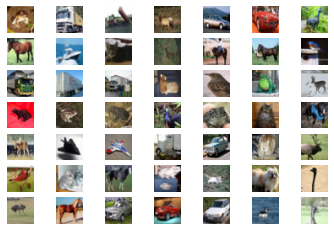

In [4]:
for i in range(49):
    plt.subplot(7,7,1+i)
    plt.imshow((X_train[i] * 127.5 + 127.5) / 255) 
    plt.axis('off')

In [5]:
def generator():
    model = tf.keras.Sequential()

    model.add(layers.Dense(4*4*256, input_shape = (100, )))
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4,4,256)))
    assert model.output_shape == (None, 4, 4, 256)

    model.add(layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding='same'))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding='same'))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(128, (8,8), padding='same'))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding='same'))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (3,3), activation='tanh', padding='same'))
    return model

In [6]:
gen = generator()
gen.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       2

In [7]:
noise = tf.random.normal([1,100])
sample_image = gen(noise, training=False)
plt.imshow(sample_image[0,:,:,0])

KeyboardInterrupt: 

In [ ]:
def discriminator():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3,3), padding ='same', input_shape = [32,32,3]))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (6,6), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten()) 
    model.add(layers.Dense(1))
    
    return model

In [ ]:
dis = discriminator()
dis.summary()

In [ ]:
EPOCHS = 500
examples_to_generate = 9
noise_dims = 100
seed = tf.random.normal([examples_to_generate, noise_dims])

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_out, fake_out):
    real_loss = cross_entropy(tf.ones_like(real_out), real_out)
    fake_loss = cross_entropy(tf.zeros_like(fake_out), fake_out)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_out):
    return cross_entropy(tf.ones_like(fake_out), fake_out)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=gen,
                                 discriminator=dis)


In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dims])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gen(noise, training=True)
    
        real_output = dis(images, training=True)
        fake_output = dis(generated_images, training=True)
    
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, dis.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(gen,
                                epoch + 1,
                                seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(gen,
                            epochs,
                            seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(3,3))

    for i in range(predictions.shape[0]):
        plt.subplot(3, 3, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5) / 255 , interpolation="bicubic")
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.close(fig)

def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

train(train_dataset, EPOCHS)

In [14]:
Gif_out = 'CIFAR_10_250_EPOCH.gif'

with imageio.get_writer(Gif_out, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)